In [1]:
%matplotlib inline


In [2]:
%pip install wordcloud


  Using cached wordcloud-1.9.4-cp310-cp310-win_amd64.whl.metadata (3.5 kB)
Using cached wordcloud-1.9.4-cp310-cp310-win_amd64.whl (299 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install -U kaleido

  Using cached kaleido-1.0.0-py3-none-any.whl.metadata (5.6 kB)
  Using cached choreographer-1.0.9-py3-none-any.whl.metadata (5.6 kB)
  Using cached logistro-1.1.0-py3-none-any.whl.metadata (2.6 kB)
  Using cached orjson-3.11.1-cp310-cp310-win_amd64.whl.metadata (43 kB)
  Using cached simplejson-3.20.1-cp310-cp310-win_amd64.whl.metadata (3.4 kB)
Using cached kaleido-1.0.0-py3-none-any.whl (51 kB)
Using cached choreographer-1.0.9-py3-none-any.whl (51 kB)
Using cached logistro-1.1.0-py3-none-any.whl (7.9 kB)
Using cached orjson-3.11.1-cp310-cp310-win_amd64.whl (131 kB)
Using cached simplejson-3.20.1-cp310-cp310-win_amd64.whl (75 kB)

   ---------------------------------------- 0/5 [simplejson]
   ---------------------------------------- 0/5 [simplejson]
   ---------------------------------------- 0/5 [simplejson]
   ---------------------------------------- 0/5 [simplejson]
   ---------------------------------------- 0/5 [simplejson]
   ---------------------------------------- 0/5 [simple

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import CSS4_COLORS, to_rgb, to_hex
import numpy as np
import re


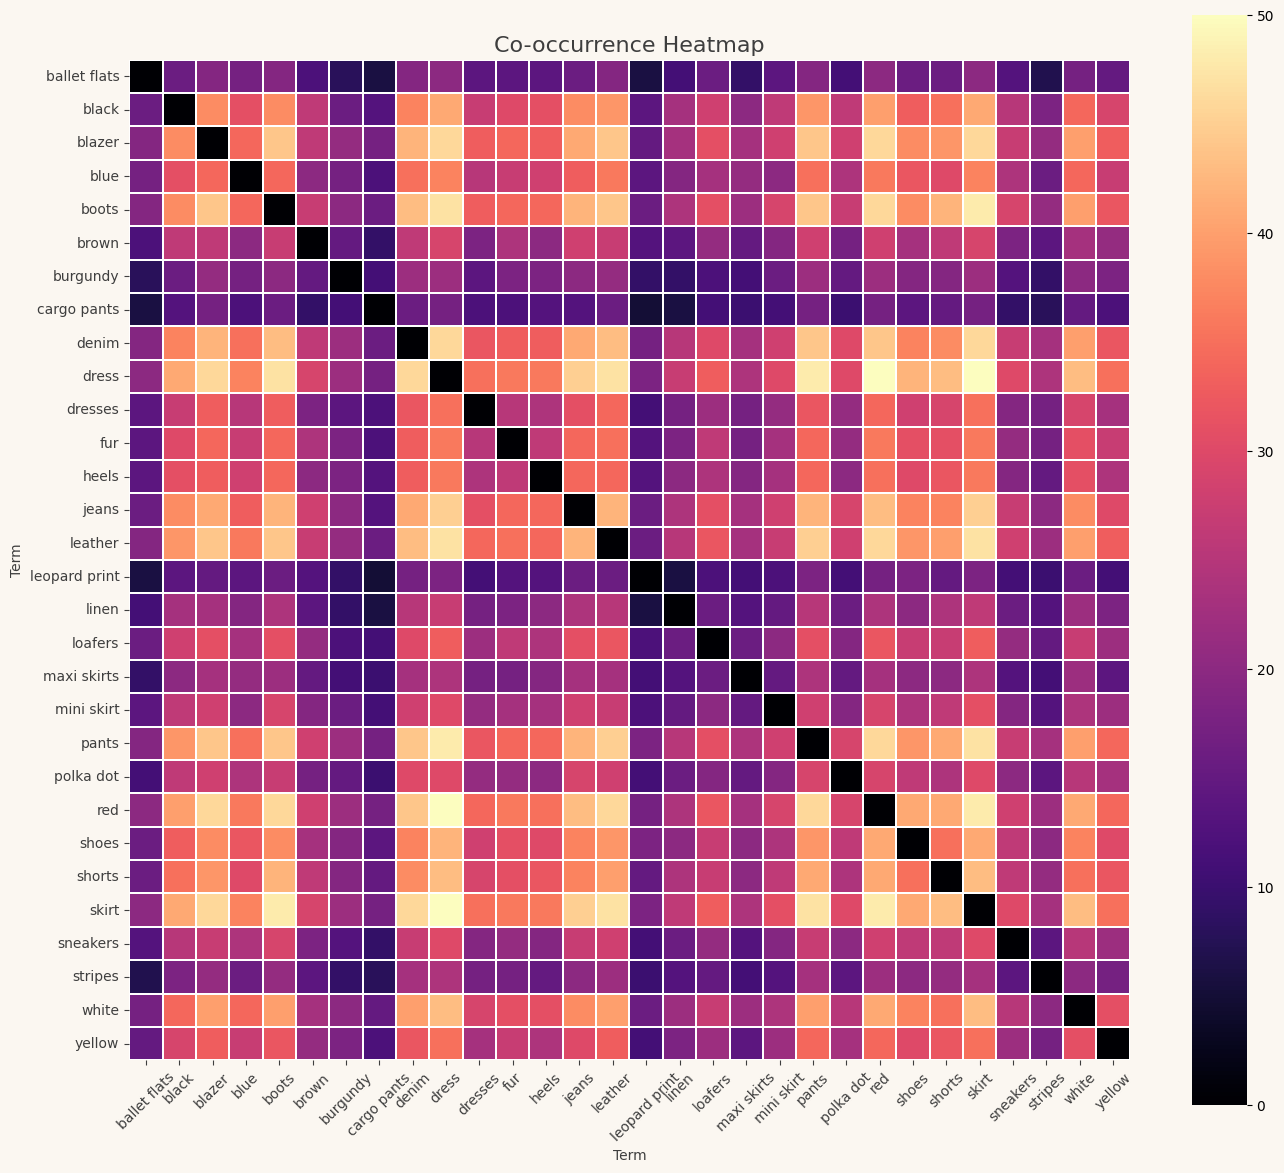

In [5]:
df = pd.read_csv("fashion_terms_cleaned.csv")

df['term_clean'] = df['term'].str.lower().str.strip()

top_terms = df['term_clean'].value_counts().head(30).index.tolist()


matched_rows = []
for trend in top_terms:
    matched = df[df['term_clean'].str.contains(trend, case=False, na=False)].copy()
    matched['standardized_trend'] = trend
    matched_rows.append(matched)

df_matched = pd.concat(matched_rows, ignore_index=True)

cooccurrence_list = []
for idx, group in df_matched.groupby("index"):
    terms = group['standardized_trend'].unique()
    if len(terms) > 1:
        for term1, term2 in combinations(sorted(terms), 2):
            cooccurrence_list.append((term1, term2))

symm_pairs = cooccurrence_list + [(b, a) for a, b in cooccurrence_list]
pair_df = pd.DataFrame(Counter(symm_pairs).items(), columns=["pair", "count"])
pair_df[['term1', 'term2']] = pd.DataFrame(pair_df['pair'].tolist(), index=pair_df.index)


heatmap_df = pair_df.pivot(index='term1', columns='term2', values='count').fillna(0)
all_terms = sorted(set(heatmap_df.index) | set(heatmap_df.columns))
heatmap_df = heatmap_df.reindex(index=all_terms, columns=all_terms, fill_value=0)


plt.figure(figsize=(14, 12), facecolor='#fbf7f1')
ax = sns.heatmap(
    heatmap_df,
    cmap="magma",
    linewidths=0.3,
    square=True,
    cbar=True
)

ax.set_title("Co-occurrence Heatmap", fontsize=16, color='#3e3e3e')
ax.set_xlabel("Term", color='#3e3e3e')
ax.set_ylabel("Term", color='#3e3e3e')
ax.tick_params(axis='x', colors='#3e3e3e', rotation=45)
ax.tick_params(axis='y', colors='#3e3e3e', rotation=0)
ax.set_facecolor('#fbf7f1')
plt.gcf().patch.set_facecolor('#fbf7f1')


plt.tight_layout()
plt.savefig("cooccurrence_heatmap_final.png", dpi=300, transparent=False)
plt.show()


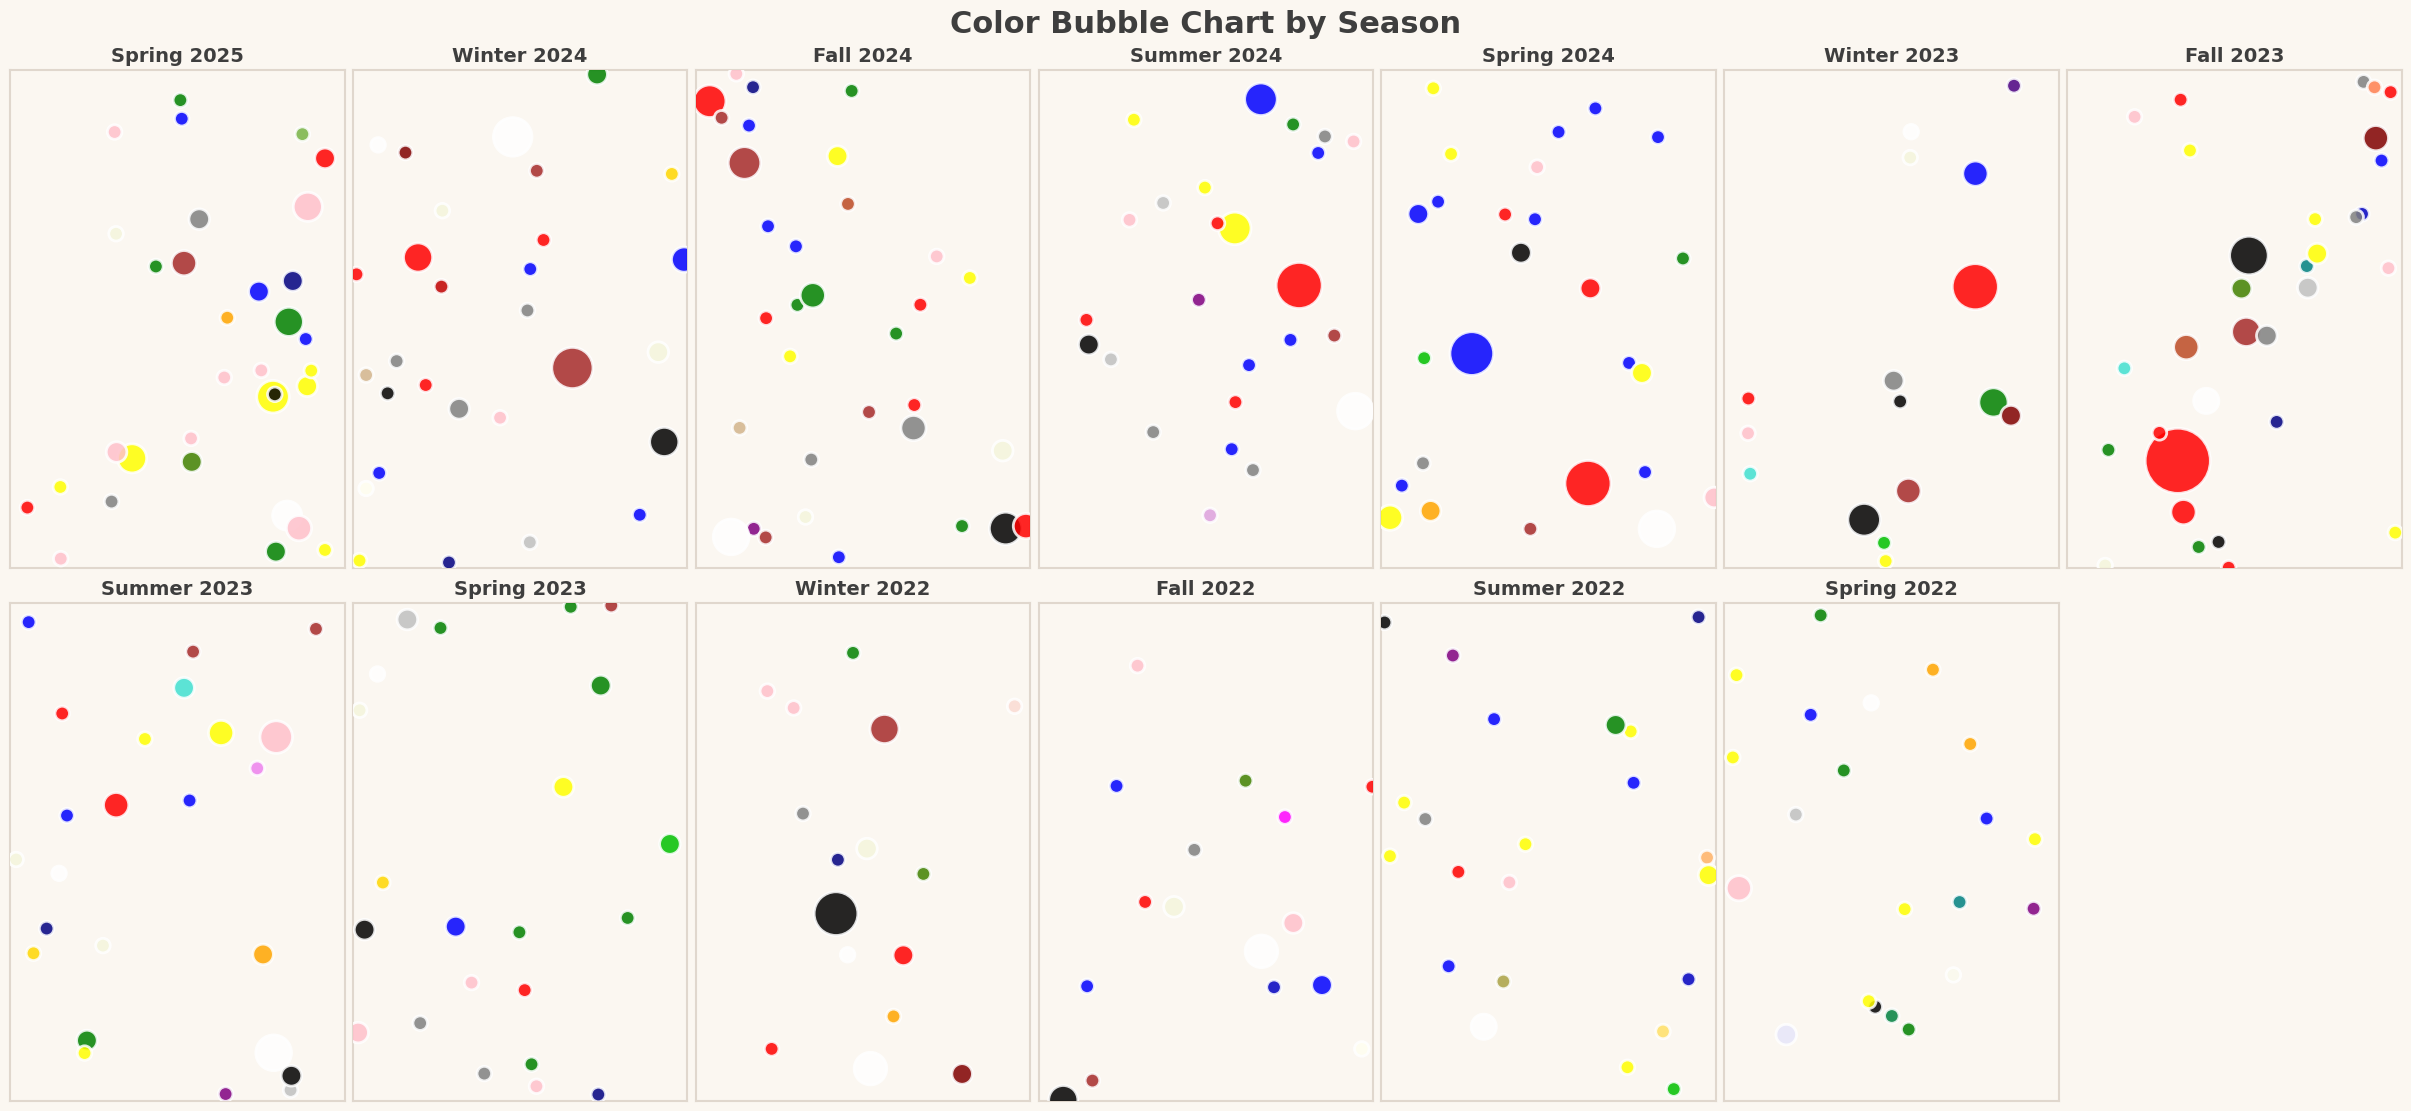

In [6]:
csv_path = "fashion_terms_cleaned.csv"
df = pd.read_csv(csv_path)

color_df = df[df['category'].str.lower() == 'colors'].copy()
color_df['term_clean'] = color_df['term'].str.lower().str.strip()

def season_sort_key_desc(season):
    parts = season.lower().split()
    season_word = parts[0]
    year = next((int(s) for s in parts if s.isdigit()), 0)
    season_weight = {'spring': 1, 'summer': 2, 'fall': 3, 'winter': 4}.get(season_word, 0)
    return -(year * 10 + season_weight)

color_df['season_sort'] = color_df['season'].apply(season_sort_key_desc)
color_df = color_df.sort_values('season_sort')

css_color_names = {name.lower(): hexcode for name, hexcode in CSS4_COLORS.items()}
def is_known_css_color(term):
    words = term.lower().split()
    return any(word in css_color_names for word in words)

color_df = color_df[color_df['term_clean'].apply(is_known_css_color)]


def extract_blended_color(term):
    words = re.findall(r'\w+', term.lower())
    matched_colors = [to_rgb(css_color_names[word]) for word in words if word in css_color_names]
    if not matched_colors:
        return '#cccccc'
    blended_rgb = np.mean(matched_colors, axis=0)
    return to_hex(blended_rgb)

color_df['hex'] = color_df['term_clean'].apply(extract_blended_color)


bubble_df = (
    color_df.groupby(['season', 'term_clean', 'hex'])
    .size()
    .reset_index(name='count')
)
bubble_df['season_sort'] = bubble_df['season'].apply(season_sort_key_desc)
bubble_df = bubble_df.sort_values('season_sort')


seasons = bubble_df['season'].unique()
fig, axs = plt.subplots(nrows=2, ncols=int(np.ceil(len(seasons)/2)), figsize=(24, 11), constrained_layout=True)
axs = axs.flatten()


for ax, season in zip(axs, seasons):
    season_data = bubble_df[bubble_df['season'] == season]
    sizes = season_data['count'] * 110
    colors = season_data['hex']
    x = np.random.rand(len(sizes))
    y = np.random.rand(len(sizes))

    ax.scatter(
        x, y, s=sizes, c=colors, alpha=0.85,
        edgecolors='white', linewidths=2.0, zorder=3
    )
    ax.set_title(season.title(), fontsize=14, fontweight='bold', color='#3e3e3e')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_facecolor('#fbf7f1')  

    for spine in ax.spines.values():
        spine.set_edgecolor('#e0d7cd')
        spine.set_linewidth(1.5)


for i in range(len(seasons), len(axs)):
    axs[i].axis('off')


fig.patch.set_facecolor('#fbf7f1')  
fig.suptitle("Color Bubble Chart by Season", fontsize=22, fontweight='bold', color='#3e3e3e')


plt.savefig("color_bubble_chart.png", dpi=300, transparent=False)
plt.show()


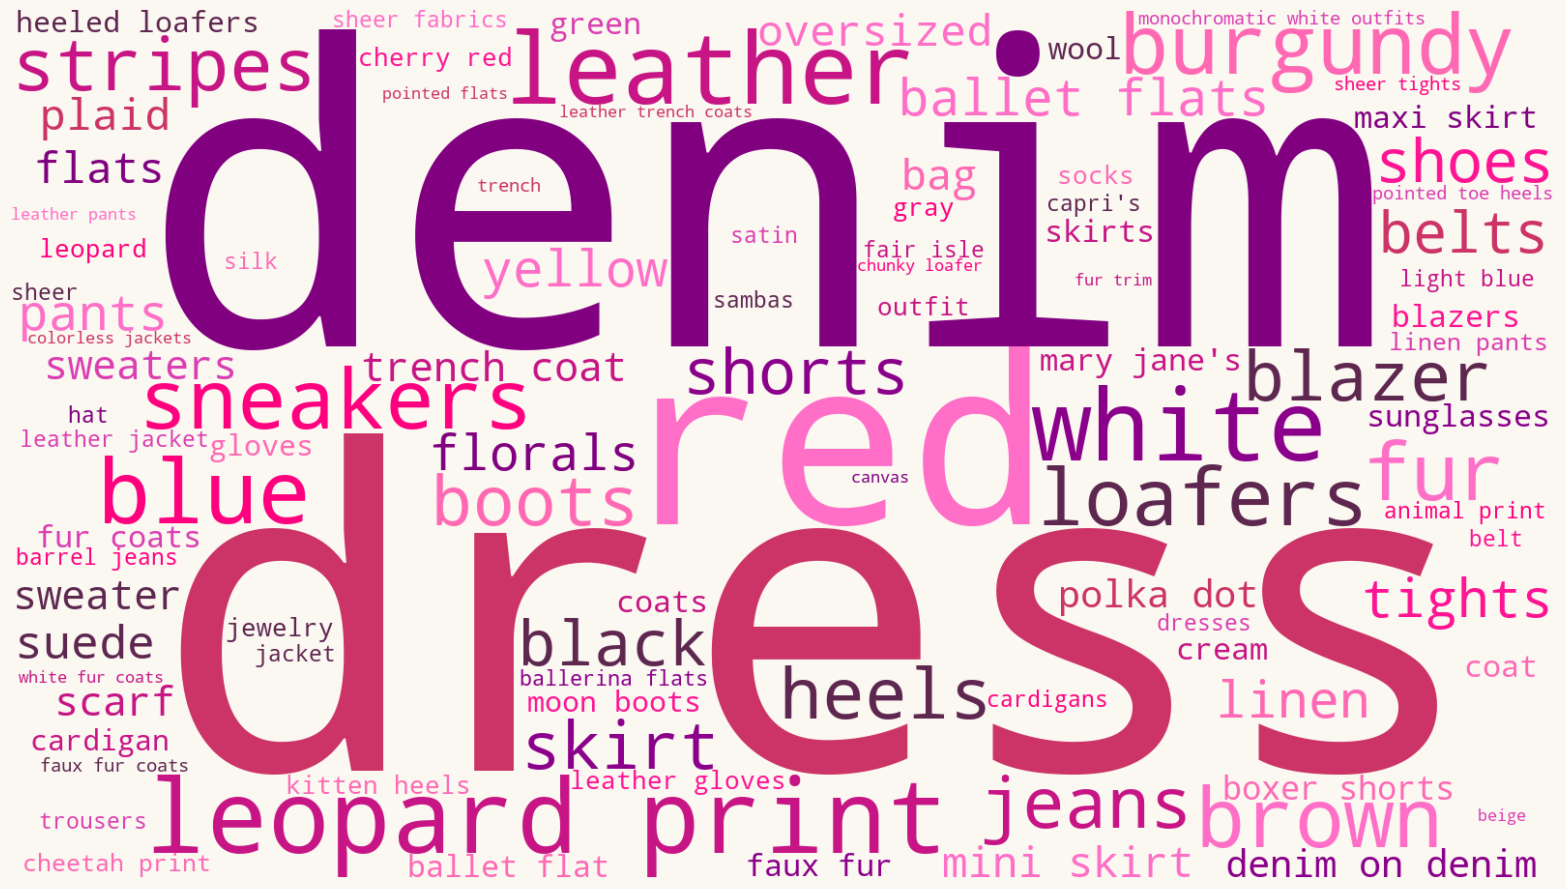

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import random


csv_path = "fashion_terms_cleaned.csv"
df = pd.read_csv(csv_path)


df['year'] = df['season'].str.extract(r'(\d{2,4})').astype(str)
df_2024 = df[df['year'].str.endswith("24")]


terms_2024 = df_2024['term'].str.lower().str.strip().tolist()
term_counts = Counter(terms_2024)
def girly_edgy_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    girly_edgy_colors = [
        "#ff69b4", "#ff1493", "#db3eb1", "#c71585", "#8b008b",
        "#800080", "#ff007f", "#cc3366", "#ff6ec7", "#5e2750"
    ]
    return random.choice(girly_edgy_colors)


wc = WordCloud(
    width=1600,
    height=900,
    background_color="#fbf7f1",  
    prefer_horizontal=1.0,
    min_font_size=10,
    max_words=100
).generate_from_frequencies(term_counts)

wc = wc.recolor(color_func=girly_edgy_color_func)


plt.figure(figsize=(16, 9), facecolor="#fbf7f1")
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.tight_layout()
plt.savefig("wordcloud_2024_trends_girly_edgy.png", dpi=300, transparent=False)
plt.show()


In [8]:
%pip install networkx


  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
Using cached networkx-3.4.2-py3-none-any.whl (1.7 MB)
Note: you may need to restart the kernel to use updated packages.


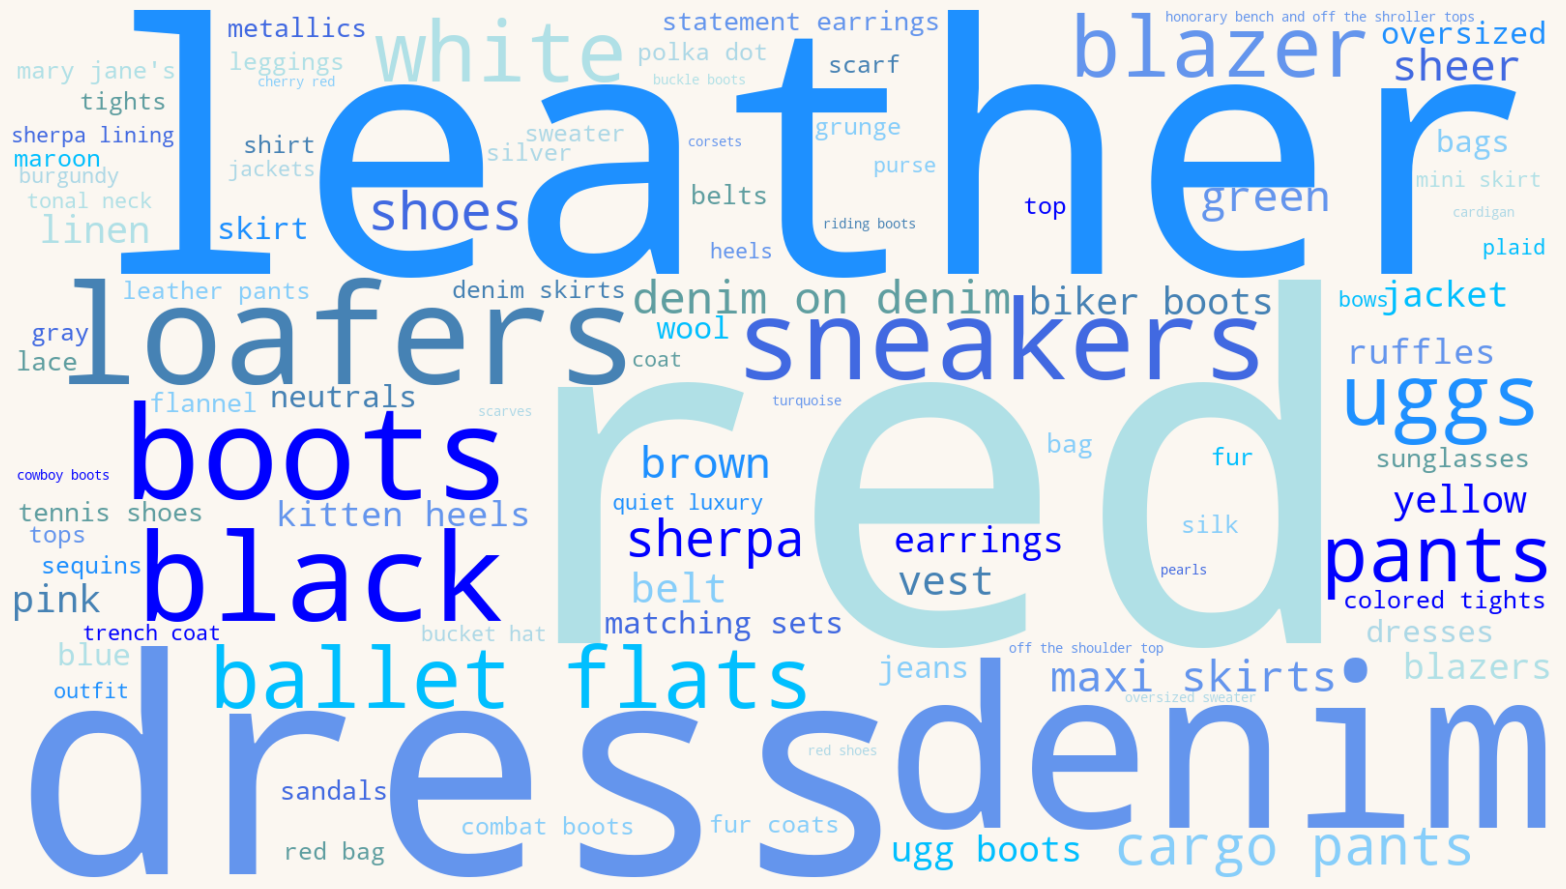

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import random


csv_path = "fashion_terms_cleaned.csv"  
df = pd.read_csv(csv_path)


df['year'] = df['season'].str.extract(r'(\d{2,4})').astype(str)
df_2023 = df[df['year'].str.endswith("23")]


terms_2023 = df_2023['term'].str.lower().str.strip().tolist()
term_counts_2023 = Counter(terms_2023)


def blue_shades_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    blue_shades = [
        "#0000ff", "#1e90ff", "#6495ed", "#4169e1", "#4682b4",
        "#87cefa", "#00bfff", "#5f9ea0", "#add8e6", "#b0e0e6"
    ]
    return random.choice(blue_shades)


wc_blue = WordCloud(
    width=1600,
    height=900,
    background_color="#fbf7f1",  
    prefer_horizontal=1.0,
    min_font_size=10,
    max_words=100
).generate_from_frequencies(term_counts_2023)


wc_blue = wc_blue.recolor(color_func=blue_shades_color_func)


plt.figure(figsize=(16, 9), facecolor="#fbf7f1")
plt.imshow(wc_blue, interpolation="bilinear")
plt.axis("off")
plt.tight_layout()
plt.savefig("wordcloud_2023_trends_blue_shades.png", dpi=300, transparent=False)
plt.show()


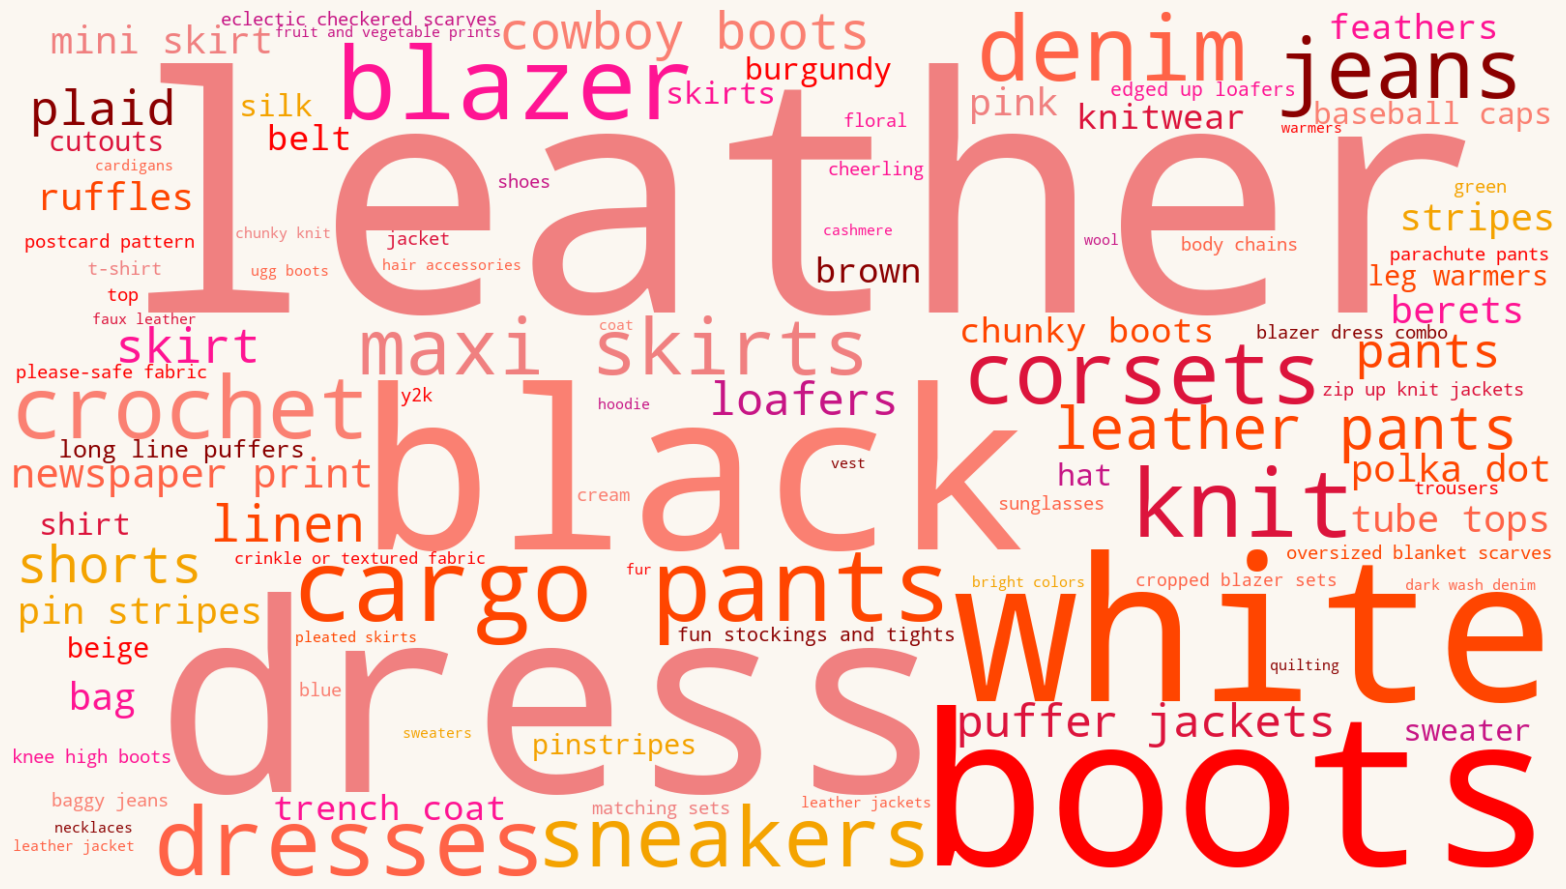

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import random


csv_path = "fashion_terms_cleaned.csv" 
df = pd.read_csv(csv_path)


df['year'] = df['season'].str.extract(r'(\d{2,4})').astype(str)
df_2022 = df[df['year'].str.endswith("22")]


terms_2022 = df_2022['term'].str.lower().str.strip().tolist()
term_counts_2022 = Counter(terms_2022)


def red_shades_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    red_shades = [
        "#ff0000", "#ff6347", "#dc143c", "#ff4500", "#8b0000",
        "#c71585", "#ff1493", "#f08080", "#fa8072", "#f4a300"
    ]
    return random.choice(red_shades)


wc_red = WordCloud(
    width=1600,
    height=900,
    background_color="#fbf7f1",  
    prefer_horizontal=1.0,
    min_font_size=10,
    max_words=100
).generate_from_frequencies(term_counts_2022)


wc_red = wc_red.recolor(color_func=red_shades_color_func)


plt.figure(figsize=(16, 9), facecolor="#fbf7f1")
plt.imshow(wc_red, interpolation="bilinear")
plt.axis("off")
plt.tight_layout()
plt.savefig("wordcloud_2022_trends_red_shades.png", dpi=300, transparent=False)
plt.show()


In [11]:
import pandas as pd
import plotly.graph_objects as go


csv_path = "fashion_terms_cleaned.csv"
df = pd.read_csv(csv_path)


df['term_clean'] = df['term'].str.lower().str.strip()


trend_terms = ['sequins', 'florals', 'polka dot', 'skirt', 'red', 'ruffles', 'leather']


df['season_clean'] = df['season'].str.split().str[0] + ' ' + df['season'].str.extract(r'(\d{4})')[0]


matched_data = []


for trend in trend_terms:
    matched_rows = df[df['term_clean'].str.contains(trend, case=False, na=False)].copy()
    matched_rows['standardized_trend'] = trend
    matched_data.append(matched_rows)


df_trends = pd.concat(matched_data, ignore_index=True)


trend_counts = df_trends.groupby(['season_clean', 'standardized_trend']).size().reset_index(name='count')


trend_pivot = trend_counts.pivot(index='season_clean', columns='standardized_trend', values='count').fillna(0)


season_order = [
    'spring 2025', 'winter 2024', 'fall 2024', 'summer 2024', 'spring 2024',
    'winter 2023', 'fall 2023', 'summer 2023', 'spring 2023',
    'winter 2022', 'fall 2022', 'summer 2022', 'spring 2022'
]
trend_pivot = trend_pivot.reindex(season_order)


fig = go.Figure()

for trend in trend_pivot.columns:
    fig.add_trace(
        go.Scatter(
            x=trend_pivot.index,
            y=trend_pivot[trend],
            mode='lines+markers',
            name=trend,
            text=trend_pivot[trend],
            hovertemplate='%{text}',
            line=dict(width=3)
        )
    )


fig.update_layout(
    title="Fashion Trends Over Seasons (2025–2022)",
    xaxis_title="Season",
    yaxis_title="Trend Count",
    xaxis=dict(tickmode='array', tickvals=trend_pivot.index, ticktext=trend_pivot.index),
    plot_bgcolor="#fbf7f1",
    paper_bgcolor="#fbf7f1",
    font=dict(family="Arial", color="#3e3e3e", size=14),
    showlegend=True,
    hoverlabel=dict(bgcolor='white', font_size=12, font_family="Arial")
)


fig.write_image("fashion_trends_line_chart.png", format="png")
fig.show()


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

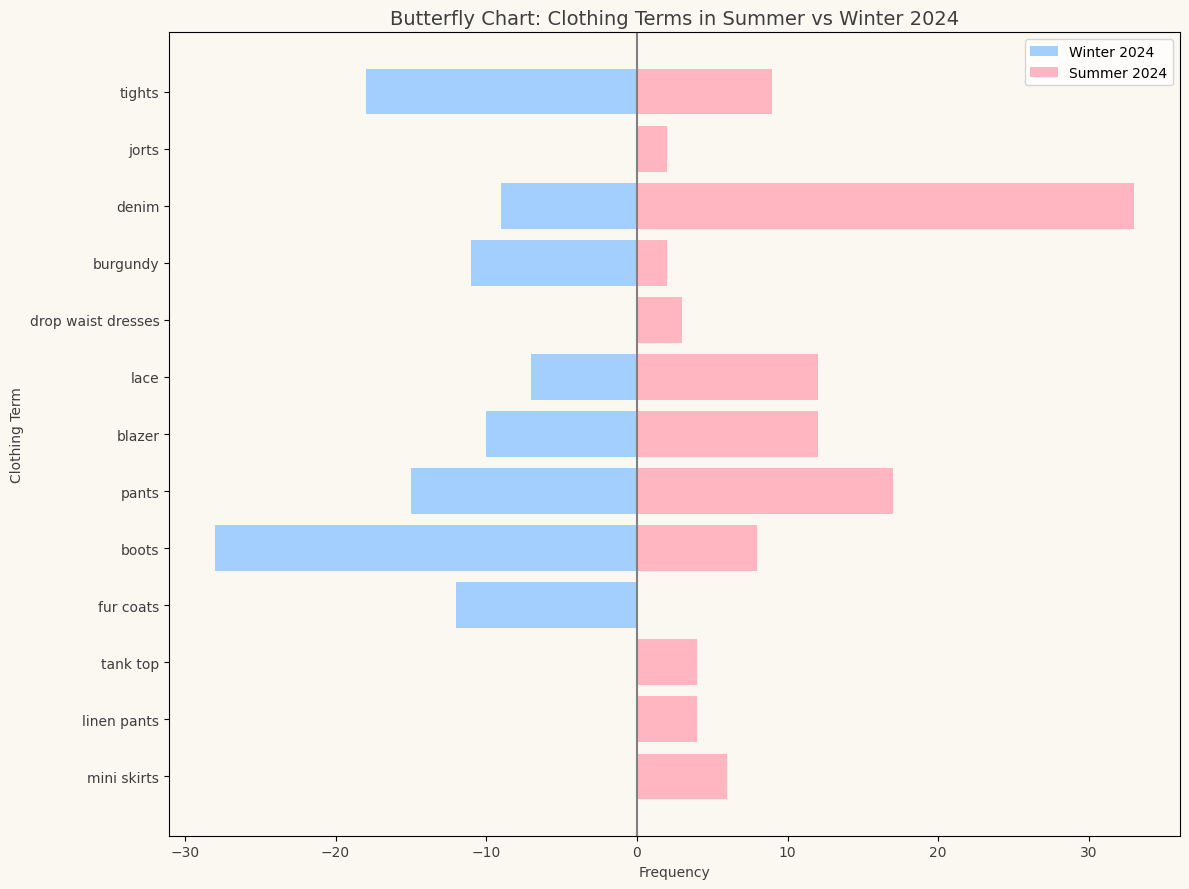

In [12]:
import pandas as pd
import matplotlib.pyplot as plt


csv_path = "fashion_terms_cleaned.csv"
df = pd.read_csv(csv_path)
df['term_clean'] = df['term'].str.lower().str.strip()
df['season_clean'] = df['season'].str.lower().str.strip()
df['category_clean'] = df['category'].str.lower().str.strip()


custom_trends = [
    'mini skirts', 'linen pants', 'tank top', 'fur coats', 'boots',
    'pants', 'blazer', 'lace', 'drop waist dresses', 'burgundy',
    'denim', 'jorts', 'tights'
]


matched_rows = []
for trend in custom_trends:
    matches = df[df['term_clean'].str.contains(trend, case=False, na=False)].copy()
    matches['standardized_trend'] = trend
    matched_rows.append(matches)

df_trends = pd.concat(matched_rows, ignore_index=True)


df_twoseasons = df_trends[df_trends['season_clean'].isin(['summer 2024', 'winter 2024'])]


trend_counts = df_twoseasons.groupby(['standardized_trend', 'season_clean']).size().reset_index(name='count')
pivot = trend_counts.pivot(index='standardized_trend', columns='season_clean', values='count').fillna(0).astype(int)


pivot = pivot.reindex(custom_trends)


plt.figure(figsize=(12, 9))
plt.barh(pivot.index, -pivot.get('winter 2024', 0), color='#a2cffe', label='Winter 2024')
plt.barh(pivot.index, pivot.get('summer 2024', 0), color='#ffb6c1', label='Summer 2024')
plt.axvline(0, color='gray')
plt.title("Butterfly Chart: Clothing Terms in Summer vs Winter 2024", fontsize=14, color='#3e3e3e')
plt.xlabel("Frequency", color='#3e3e3e')
plt.ylabel("Clothing Term", color='#3e3e3e')
plt.gca().set_facecolor('#fbf7f1')
plt.gcf().set_facecolor('#fbf7f1')
plt.xticks(color='#3e3e3e')
plt.yticks(color='#3e3e3e')
plt.legend()
plt.grid(False)
output_path = "custom_butterfly_chart_substring_matched.png"

plt.tight_layout()
plt.savefig(output_path, dpi=300, transparent=False)

plt.show()




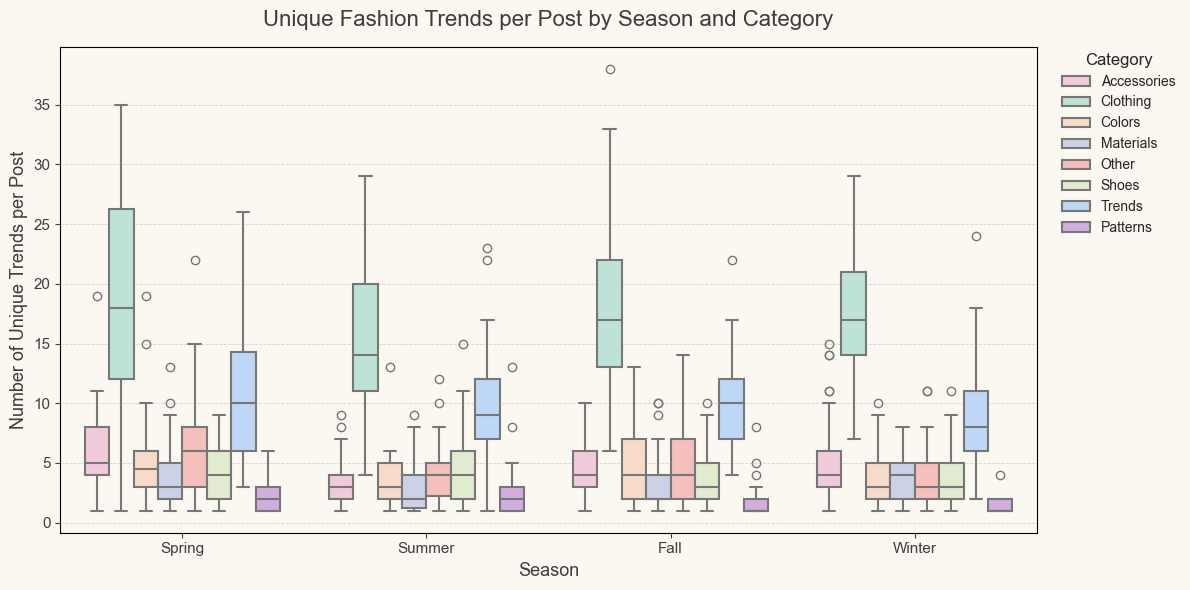

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("fashion_terms_cleaned.csv")
df['term_clean'] = df['term'].str.lower().str.strip()
df['category'] = df['category'].str.strip().str.capitalize()
df['season_name'] = df['season'].str.extract(r'([a-zA-Z]+)')[0].str.capitalize()
df['year'] = df['season'].str.extract(r'(\d{4})')[0].astype(int)
season_order = ['Spring', 'Summer', 'Fall', 'Winter']
df['season_name'] = pd.Categorical(df['season_name'], categories=season_order, ordered=True)

term_per_post_cat = df.groupby(['index', 'season_name', 'category'], observed=True)['term_clean'].nunique().reset_index()
term_per_post_cat.columns = ['post_id', 'season', 'category', 'unique_term_count']

pastel_palette = ['#f7c3da', '#b5ead7', '#ffdac1', '#c7ceea', '#ffb7b2', '#e2f0cb', '#b5d6ff', '#d5a6e6']

fig, ax = plt.subplots(figsize=(12, 6), facecolor='#fbf7f1')
sns.set_style("whitegrid")

sns.boxplot(
    data=term_per_post_cat,
    x='season',
    y='unique_term_count',
    hue='category',
    palette=pastel_palette,
    linewidth=1.5,
    ax=ax
)

ax.set_facecolor('#fbf7f1')
ax.set_title("Unique Fashion Trends per Post by Season and Category", fontsize=16, color='#3e3e3e', pad=15)
ax.set_xlabel("Season", fontsize=13, color='#3e3e3e')
ax.set_ylabel("Number of Unique Trends per Post", fontsize=13, color='#3e3e3e')
ax.tick_params(axis='x', labelsize=11, colors='#3e3e3e')
ax.tick_params(axis='y', labelsize=11, colors='#3e3e3e')
ax.grid(axis='y', linestyle='--', linewidth=0.6, alpha=0.5)

ax.legend(
    title='Category',
    title_fontsize=12,
    fontsize=10,
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0.,
    frameon=False
)

plt.tight_layout()
plt.savefig("boxplot_trends_per_post_by_category_pastel.png", dpi=300, transparent=False)
plt.show()


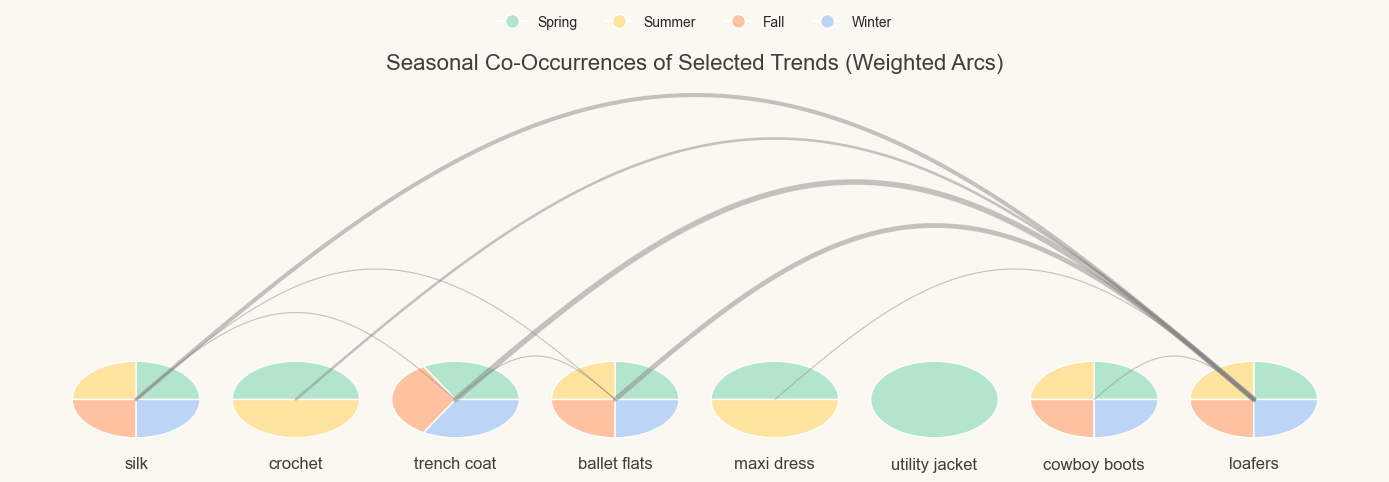

'selected_trends_arc_plot_final_weighted.png'

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from matplotlib.patches import Wedge
from matplotlib.lines import Line2D


df = pd.read_csv("fashion_terms_cleaned.csv")


df['year'] = df['season'].str.extract(r'(\d{4})').astype(int)
df['season_name'] = df['season'].str.extract(r'([a-zA-Z]+)')[0].str.lower()
df = df[df['year'].between(2022, 2025)].copy()
df['term_clean'] = df['term'].str.lower().str.strip()


selected_trends = [
    'silk', 'crochet', 'trench coat', 'ballet flats',
    'maxi dress', 'utility jacket', 'cowboy boots', 'loafers'
]


term_season_map = {trend: [] for trend in selected_trends}
for season in ['spring', 'summer', 'fall', 'winter']:
    season_df = df[df['season_name'] == season]
    for trend in selected_trends:
        if season_df['term_clean'].str.contains(trend, na=False).any():
            term_season_map[trend].append(season)


season_colors = {
    'spring': '#b3e5cc',
    'summer': '#ffe39f',
    'fall': '#ffc2a1',
    'winter': '#bcd4f5'
}


fig, ax = plt.subplots(figsize=(14, 6), facecolor='#fbf7f1')
ax.set_facecolor('#fbf7f1')
ax.axis('off')


positions = {term: i for i, term in enumerate(selected_trends)}


for i, term in enumerate(selected_trends):
    center = (i, 0)
    active_seasons = term_season_map.get(term, [])
    n = len(active_seasons)
    for j, season in enumerate(active_seasons):
        theta1 = 360 * j / n
        theta2 = 360 * (j + 1) / n
        wedge = Wedge(center, 0.4, theta1, theta2,
                      facecolor=season_colors[season],
                      edgecolor='white', linewidth=1)
        ax.add_patch(wedge)
    ax.text(i, -0.6, term, ha='center', va='top', fontsize=12, color='#3e3e3e')


G = nx.Graph()
G.add_nodes_from(selected_trends)


df_filtered = df[df['term_clean'].apply(lambda x: any(trend in x for trend in selected_trends))]


for idx, group in df_filtered.groupby("index"):
    terms = group['term_clean'].tolist()
    matched = [t for t in selected_trends if any(t in term for term in terms)]
    for i in range(len(matched)):
        for j in range(i + 1, len(matched)):
            if G.has_edge(matched[i], matched[j]):
                G[matched[i]][matched[j]]['weight'] += 1
            else:
                G.add_edge(matched[i], matched[j], weight=1)


edges = [(u, v, d['weight']) for u, v, d in G.edges(data=True) if d['weight'] >= 10]
weights = [w for _, _, w in edges]
min_w, max_w = (min(weights), max(weights)) if weights else (0, 1)


def scale_weight(w, min_w, max_w, min_lw=0.8, max_lw=4):
    if max_w == min_w:
        return min_lw
    return min_lw + (max_lw - min_lw) * (w - min_w) / (max_w - min_w)


for u, v, weight in edges:
    if u in positions and v in positions:
        x1, x2 = positions[u], positions[v]
        arc_x = np.linspace(x1, x2, 100)
        arc_y = np.sin(np.linspace(0, np.pi, 100)) * (abs(x2 - x1) / 2.2)
        lw = scale_weight(weight, min_w, max_w)
        ax.plot(arc_x, arc_y, color='gray', alpha=0.45, linewidth=lw)


legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=season.capitalize(),
           markerfacecolor=color, markersize=10)
    for season, color in season_colors.items()
]
ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.2),
          ncol=4, frameon=False, fontsize=10)


ax.set_title("Seasonal Co-Occurrences of Selected Trends (Weighted Arcs)", fontsize=16, color='#3e3e3e')
plt.tight_layout(rect=[0, 0, 1, 0.85])
output_path = "selected_trends_arc_plot_final_weighted.png"
plt.savefig(output_path, dpi=300, transparent=False)
plt.show()

output_path


C:\Users\santh\AppData\Local\Temp\ipykernel_14164\1126483450.py:18: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



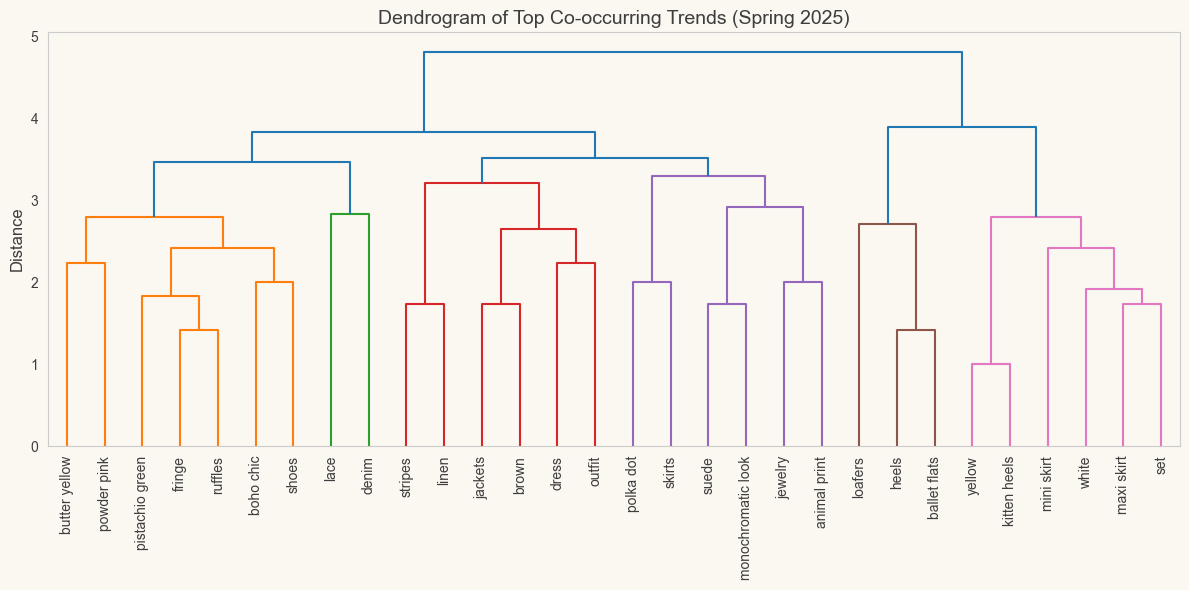

In [15]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

df = pd.read_csv("fashion_terms_cleaned.csv")
df['term_clean'] = df['term'].str.lower().str.strip()
df['season'] = df['season'].str.strip().str.capitalize()
df_spring2025 = df[df['season'] == 'Spring 2025']

post_term_matrix = df_spring2025.pivot_table(
    index='index',
    columns='term_clean',
    aggfunc='size',
    fill_value=0
)

post_term_matrix = post_term_matrix.applymap(lambda x: 1 if x > 0 else 0)
top_terms = post_term_matrix.sum().sort_values(ascending=False).head(30).index
filtered_matrix = post_term_matrix[top_terms]

linked = linkage(filtered_matrix.T, method='ward')

plt.figure(figsize=(12, 6), facecolor='#fbf7f1')
dendrogram(
    linked,
    labels=filtered_matrix.columns,
    orientation='top',
    leaf_rotation=90,
    leaf_font_size=10,
    color_threshold=0.7 * max(linked[:, 2])
)
plt.title("Dendrogram of Top Co-occurring Trends (Spring 2025)", fontsize=14, color='#3e3e3e')
plt.ylabel("Distance", fontsize=12, color='#3e3e3e')
plt.xticks(color='#3e3e3e')
plt.yticks(color='#3e3e3e')
plt.gca().set_facecolor('#fbf7f1')
plt.gcf().patch.set_facecolor('#fbf7f1')
plt.grid(False)
plt.tight_layout()
plt.savefig("spring2025_trend_dendrogram.png", dpi=300, transparent=False)
plt.show()


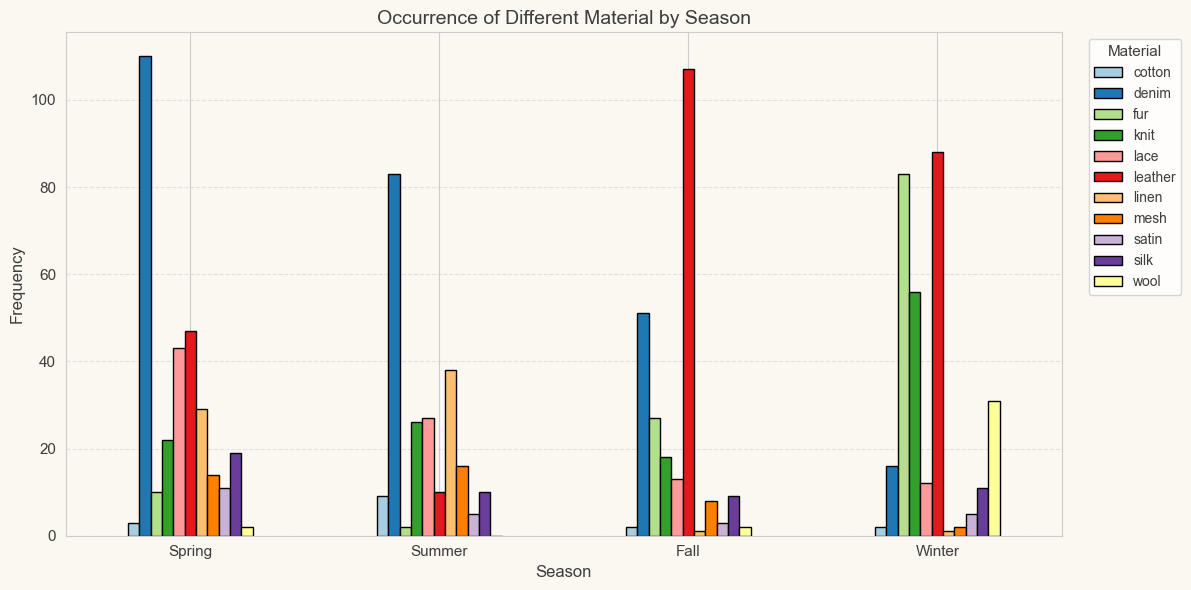

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

df = pd.read_csv("fashion_terms_cleaned.csv")
df['term_clean'] = df['term'].str.lower().str.strip()
df['season_name'] = df['season'].str.extract(r'([a-zA-Z]+)')[0].str.capitalize()

fabric_keywords = ['linen', 'fur', 'leather', 'denim', 'wool', 'cotton', 'silk', 'knit', 'mesh', 'satin', 'lace']
season_material_counts = defaultdict(lambda: defaultdict(int))

for _, row in df.iterrows():
    season = row['season_name']
    term = row['term_clean']
    for keyword in fabric_keywords:
        if keyword in term:
            season_material_counts[season][keyword] += 1

material_count_df = pd.DataFrame(season_material_counts).fillna(0).astype(int).T[sorted(fabric_keywords)]
season_order = ['Spring', 'Summer', 'Fall', 'Winter']
material_count_df = material_count_df.reindex(season_order)

fig, ax = plt.subplots(figsize=(12, 6), facecolor='#fbf7f1')
ax.set_facecolor('#fbf7f1')
material_count_df.plot(
    kind='bar',
    ax=ax,
    color=sns.color_palette("Paired", n_colors=len(fabric_keywords)),
    edgecolor='black'
)

ax.set_title("Occurrence of Different Material by Season", fontsize=14, color='#3e3e3e')
ax.set_xlabel("Season", fontsize=12, color='#3e3e3e')
ax.set_ylabel("Frequency", fontsize=12, color='#3e3e3e')
ax.tick_params(axis='x', colors='#3e3e3e', labelrotation=0, labelsize=11)
ax.tick_params(axis='y', colors='#3e3e3e', labelsize=11)
ax.grid(axis='y', linestyle='--', alpha=0.5)

legend = ax.legend(title='Material', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10, title_fontsize=11)
plt.setp(legend.get_texts(), color='#3e3e3e')
plt.setp(legend.get_title(), color='#3e3e3e')

plt.tight_layout()
plt.savefig("material_keyword_count_by_season.png", dpi=300, facecolor='#fbf7f1')
plt.show()


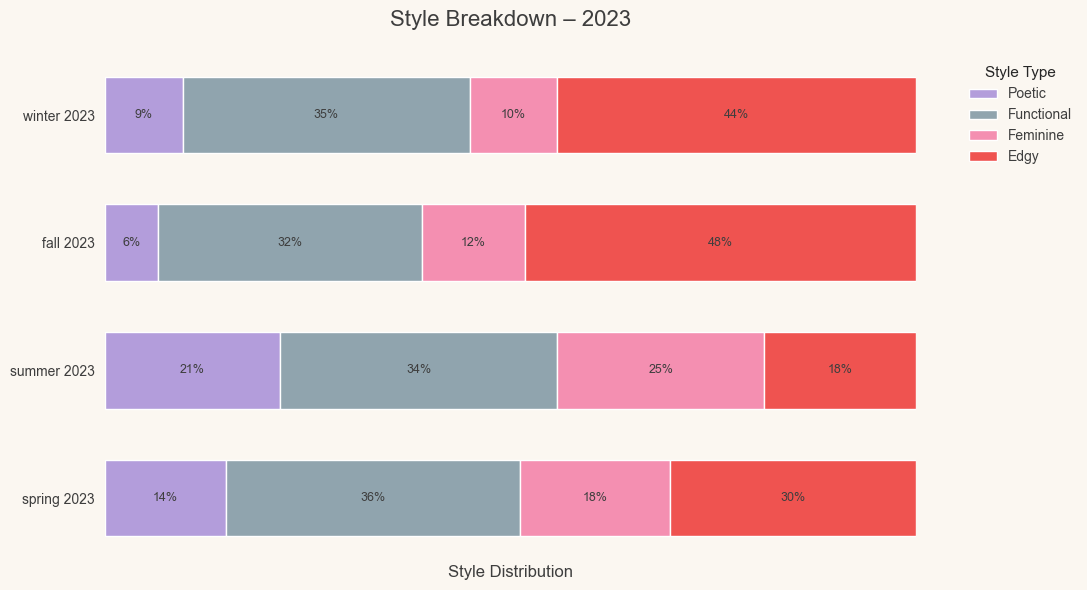

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

poetic_keywords = ["sheer", "velvet", "chiffon", "lace", "floral", "ruffle", "silk", "organza", "pastel", "buttermilk", "romantic", "tulle", "ethereal", "glitter", "glow"]
functional_keywords = ["cargo", "denim", "pocket", "zipper", "utility", "jacket", "coat", "vest", "parka", "belt", "layer", "durable", "tote", "bomber", "workwear"]
feminine_keywords = ["ballet", "lace", "ruffle", "babydoll", "pastel", "sheer", "floral", "pink", "silk", "tulle", "wrap", "frill", "bustier", "chiffon", "puff sleeve"]
edgy_keywords = ["leather", "mesh", "corset", "metallic", "stud", "spike", "combat", "biker", "goth", "punk", "distressed", "oversized", "trench", "grunge", "boot"]

df = pd.read_csv("fashion_terms_cleaned.csv")
df_2023 = df[df["season"].str.contains("2023")]

mood_2023_df = defaultdict(lambda: {"Poetic": 0, "Functional": 0, "Feminine": 0, "Edgy": 0})
for _, row in df_2023.iterrows():
    term = row["clean_term"].lower()
    season = row["season"]
    for kw in poetic_keywords:
        if kw in term:
            mood_2023_df[season]["Poetic"] += 1
            break
    for kw in functional_keywords:
        if kw in term:
            mood_2023_df[season]["Functional"] += 1
            break
    for kw in feminine_keywords:
        if kw in term:
            mood_2023_df[season]["Feminine"] += 1
            break
    for kw in edgy_keywords:
        if kw in term:
            mood_2023_df[season]["Edgy"] += 1
            break

mood_2023_prop = pd.DataFrame(mood_2023_df).T
mood_2023_prop["Total"] = mood_2023_prop.sum(axis=1)
for col in ["Poetic", "Functional", "Feminine", "Edgy"]:
    mood_2023_prop[col] = mood_2023_prop[col] / mood_2023_prop["Total"]
mood_2023_prop = mood_2023_prop.drop(columns="Total")

ordered_2023 = ["spring 2023", "summer 2023", "fall 2023", "winter 2023"]
mood_2023_prop = mood_2023_prop.loc[ordered_2023]

bar_colors = ["#b39ddb", "#90a4ae", "#f48fb1", "#ef5350"]
style_labels = ["Poetic", "Functional", "Feminine", "Edgy"]

fig, ax = plt.subplots(figsize=(11, 6), facecolor="#fbf7f1")
ax.set_facecolor("#fbf7f1")
bottoms = [0] * len(mood_2023_prop)
for i, (col, color, label) in enumerate(zip(mood_2023_prop.columns, bar_colors, style_labels)):
    bars = ax.barh(
        y=mood_2023_prop.index,
        width=mood_2023_prop[col],
        left=bottoms,
        color=color,
        edgecolor="white",
        height=0.6
    )
    for j, bar in enumerate(bars):
        width = bar.get_width()
        ax.text(
            bar.get_x() + width / 2,
            bar.get_y() + bar.get_height() / 2,
            f"{int(width * 100)}%",
            ha="center", va="center", fontsize=9, color="#3e3e3e"
        )
    bottoms = [b + w for b, w in zip(bottoms, mood_2023_prop[col])]

ax.set_title("Style Breakdown – 2023", fontsize=16, pad=20, color="#3e3e3e")
ax.set_xlabel("Style Distribution", fontsize=12, color="#3e3e3e")
ax.set_ylabel("")
ax.legend(title="Style Type", labels=style_labels, bbox_to_anchor=(1.05, 1), loc='upper left', labelcolor="#3e3e3e", title_fontsize=11, facecolor="#fbf7f1", frameon=False)
ax.set_xlim(0, 1)
ax.xaxis.set_ticks([])
ax.tick_params(colors="#3e3e3e")
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.savefig("fashion_style_bars_2023_clean.png", transparent=False, facecolor="#fbf7f1")
plt.show()
